# Rt Live Model

In [1]:
%load_ext autoreload
%autoreload 2

import pymc3 as pm
import pandas as pd
import numpy as np
import arviz as az
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
from matplotlib import pyplot as plt
from covid.models.generative import GenerativeModel
from covid.data import summarize_inference_data
%config InlineBackend.figure_format = 'retina'

from covid.data import get_and_process_covidtracking_data_il, get_and_process_covidtracking_data_ilsev, summarize_inference_data

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-ptc7m8ym because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Fetch data and select the state's data

In [2]:
df = get_and_process_covidtracking_data_il(run_date=pd.Timestamp.today())#-pd.Timedelta(days=1))
dfunn = get_and_process_covidtracking_data_il(run_date=pd.Timestamp.today(), norm=False)#-pd.Timedelta(days=1))
dfsev = get_and_process_covidtracking_data_ilsev(run_date=pd.Timestamp.today()-pd.Timedelta(days=1))

In [3]:
region = "Israel"
model_data = df.loc[region]
model_sev = dfsev.loc[region]
model_sev_dash = dfunn.loc[region]
model_sev_dash['positive'] = model_sev_dash['severe']
model_unn = dfunn.loc[region]

## Create the model instance and sample

In [4]:
gmsev = GenerativeModel(region, model_sev, buffer_days = 20, delay=2+5, sigma=0.07)
gmsev.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 2508 seconds.


In [5]:
gmsevdash = GenerativeModel(region, model_sev_dash, buffer_days = 20, delay=2+5, sigma=0.07)
gmsevdash.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 2956 seconds.


In [6]:
gmunn = GenerativeModel(region, model_unn, delay=2, sigma=0.07)
gmunn.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 1994 seconds.


## Summarize Model Output

In [7]:
resultsev = summarize_inference_data(gmsev.inference_data)
resultunn = summarize_inference_data(gmunn.inference_data)
resultsevdash = summarize_inference_data(gmsevdash.inference_data)

In [8]:
resultunn.tail(60)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2021-01-03,1.008554,1.005233,0.871465,1.125624,7936.158937,6420.944919,5230.0,5230,100000
2021-01-04,0.989818,0.984470,0.843870,1.095202,7989.425664,6663.991403,8406.0,8406,100000
2021-01-05,0.972324,0.969081,0.847839,1.089318,8009.145253,6894.378917,8237.0,8237,100000
2021-01-06,0.954578,0.945104,0.849795,1.075509,7998.869315,7108.489055,7878.0,7878,100000
2021-01-07,0.944608,0.942620,0.835352,1.053320,7961.615479,7303.201105,7645.0,7645,100000
2021-01-08,0.936080,0.930604,0.824412,1.050136,7898.392781,7475.807400,8162.0,8162,100000
2021-01-09,0.924122,0.919818,0.810043,1.028070,7814.763387,7624.243661,5158.0,5158,100000
2021-01-10,0.921668,0.917228,0.819411,1.043724,7717.420719,7747.124648,6936.0,6936,100000
2021-01-11,0.917325,0.915380,0.823405,1.048557,7606.522839,7843.607302,9712.0,9712,100000


In [9]:
resultsev.tail(60)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2021-01-02,0.984172,0.982872,0.860781,1.091264,141.831072,112.610602,89.0,89,10000
2021-01-03,0.978391,0.971562,0.862076,1.082565,141.887554,116.545098,115.0,115,10000
2021-01-04,0.969762,0.964385,0.850567,1.080582,141.571451,120.372058,132.0,132,10000
2021-01-05,0.962525,0.955115,0.825647,1.057635,140.953594,124.044728,140.0,140,10000
2021-01-06,0.953678,0.946365,0.811898,1.047563,140.130170,127.524200,142.0,142,10000
2021-01-07,0.946096,0.941151,0.829801,1.056502,139.110722,130.774558,137.0,137,10000
2021-01-08,0.942509,0.933797,0.837267,1.064536,137.879174,133.762325,122.0,122,10000
2021-01-09,0.938592,0.933161,0.830059,1.043544,136.441553,136.459445,118.0,118,10000
2021-01-10,0.930580,0.924690,0.816914,1.033747,134.868817,138.845627,150.0,150,10000


In [10]:
resultsevdash.tail(60)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2021-01-03,0.978810,0.977607,0.853572,1.084536,132.160383,109.846283,108.0,108.0,100000
2021-01-04,0.969268,0.971319,0.852694,1.081264,131.797999,113.407707,121.0,121.0,100000
2021-01-05,0.962845,0.957791,0.848291,1.079685,131.244549,116.829817,139.0,139.0,100000
2021-01-06,0.958686,0.951793,0.828462,1.069464,130.491532,120.070711,135.0,135.0,100000
2021-01-07,0.955066,0.948110,0.832467,1.075096,129.543264,123.090506,123.0,123.0,100000
2021-01-08,0.948440,0.941224,0.852301,1.080089,128.459135,125.854079,116.0,116.0,100000
2021-01-09,0.942963,0.939409,0.808893,1.047354,127.283083,128.333398,115.0,115.0,100000
2021-01-10,0.940214,0.935415,0.825732,1.072676,125.989509,130.508417,133.0,133.0,100000
2021-01-11,0.936680,0.932866,0.816541,1.067008,124.561315,132.366677,148.0,148.0,100000


## Plot Model Output

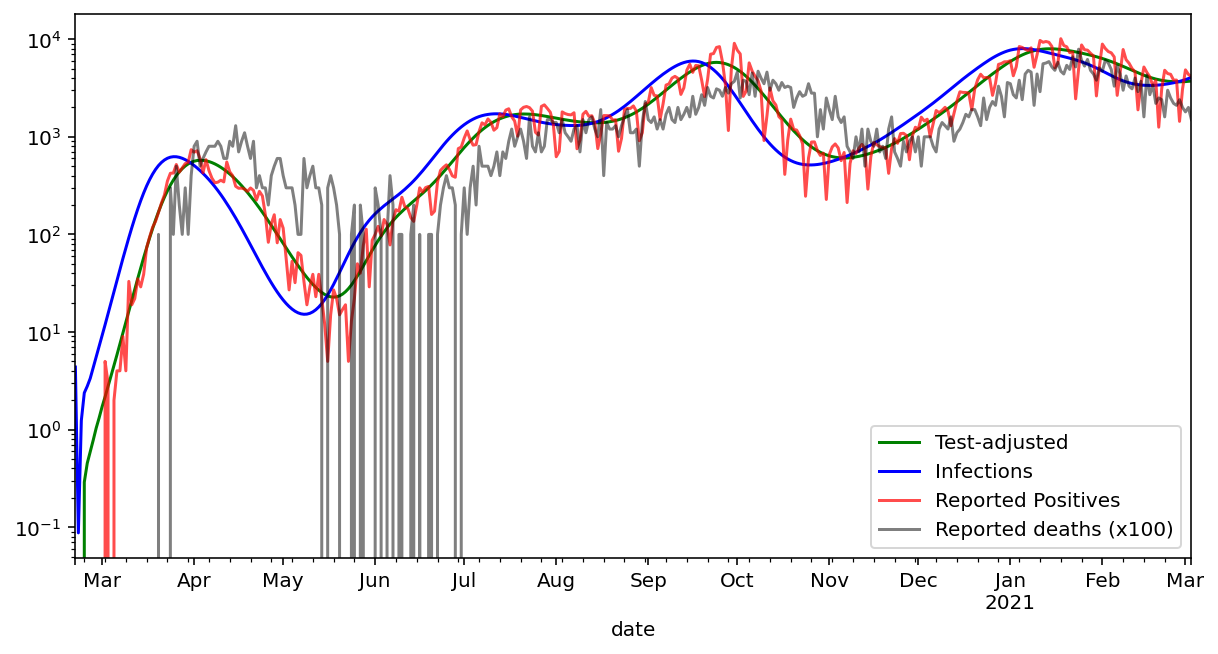

In [11]:
fig, ax = plt.subplots(figsize=(10,5))
resultunn.test_adjusted_positive.plot(c="g", label="Test-adjusted")
#resultunn.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
resultunn.infections.plot(c="b", label="Infections")
gmunn.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
d = gmunn.observed.deaths * 100
d.plot(c='k', alpha=0.5, label="Reported deaths (x100)")
plt.yscale("log")
fig.set_facecolor('w')
ax.legend();

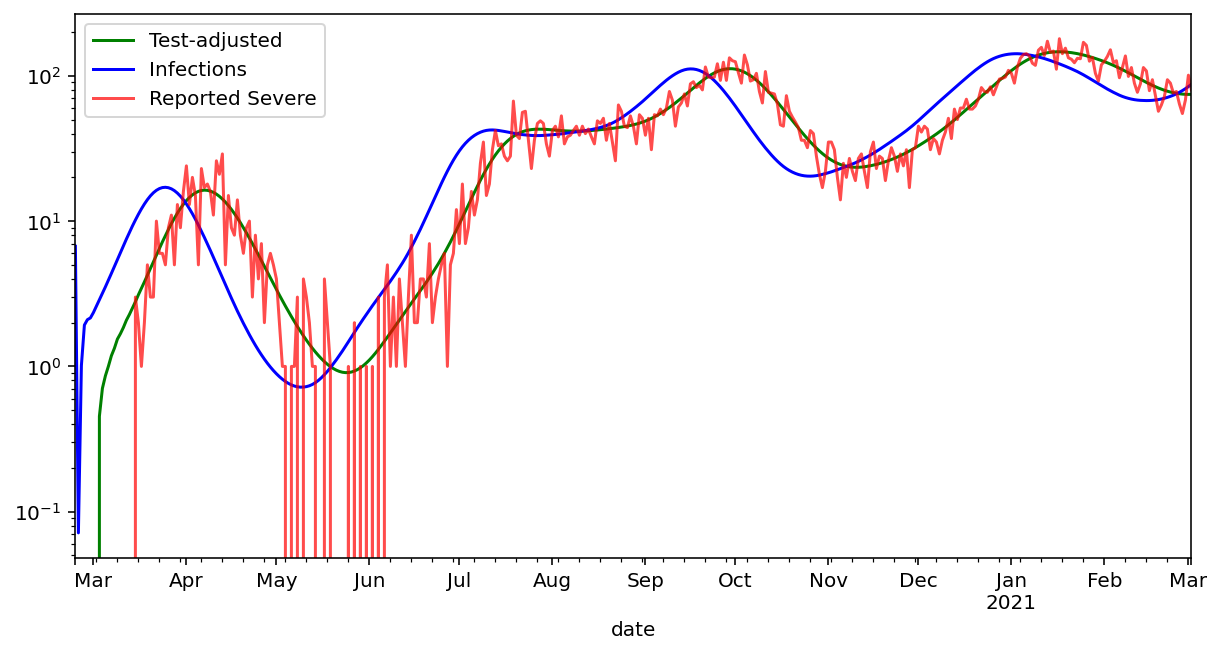

In [12]:
fig, ax = plt.subplots(figsize=(10,5))
resultsev.test_adjusted_positive.plot(c="g", label="Test-adjusted")
#resultsev.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
resultsev.infections.plot(c="b", label="Infections")
gmsev.observed.positive.plot(c='r', alpha=.7, label="Reported Severe")
fig.set_facecolor('w')
plt.yscale("log")
ax.legend();

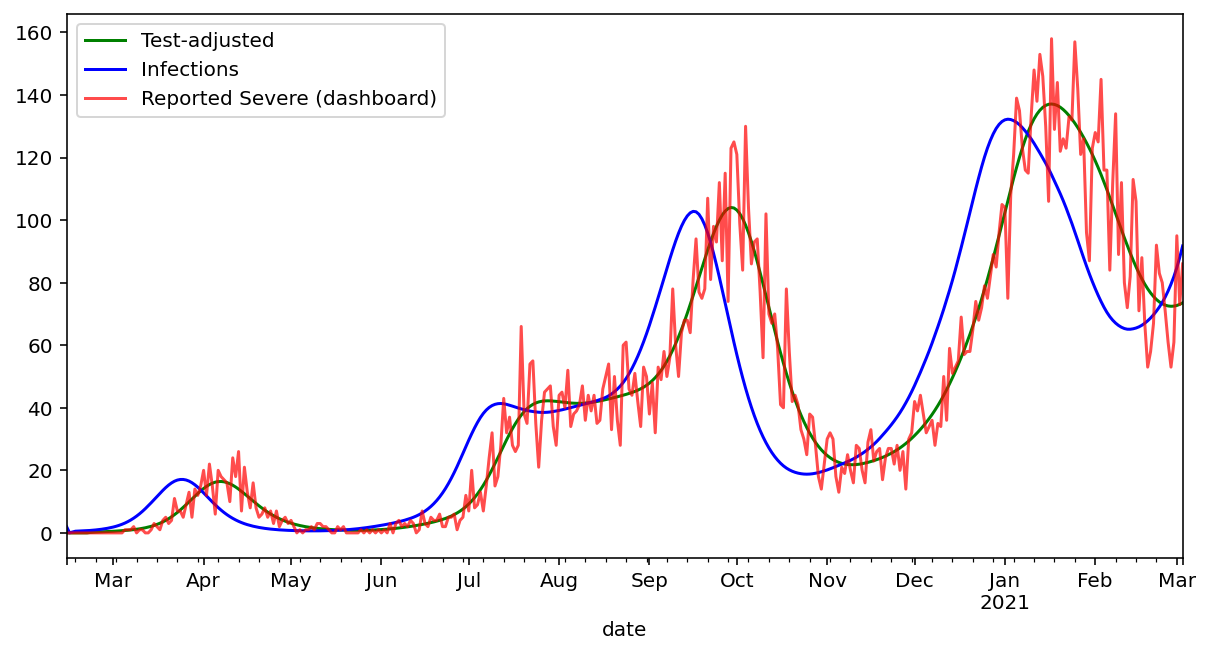

In [13]:
fig, ax = plt.subplots(figsize=(10,5))
resultsevdash.test_adjusted_positive.plot(c="g", label="Test-adjusted")
#resultsev.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
resultsevdash.infections.plot(c="b", label="Infections")
gmsevdash.observed.positive.plot(c='r', alpha=.7, label="Reported Severe (dashboard)")
fig.set_facecolor('w')
ax.legend();

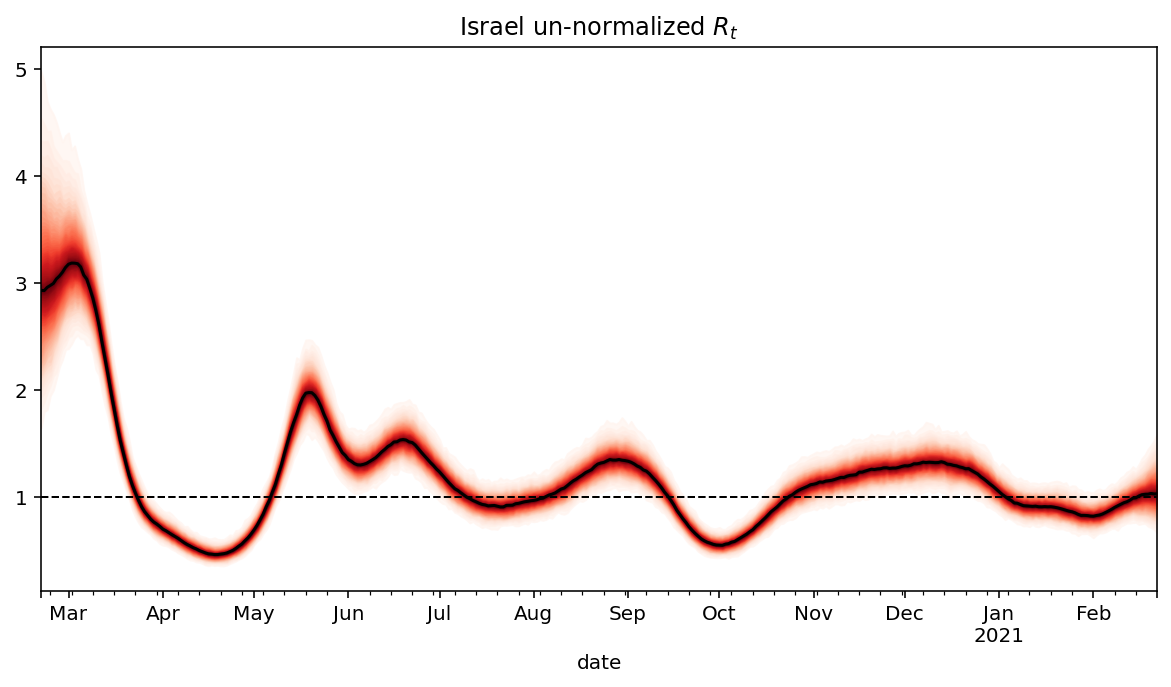

In [14]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"{region} un-normalized $R_t$")
samples = gmunn.trace['r_t']
x=resultunn.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

resultunn["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
#ax.set_xlim(left = pd.Timestamp.today()-pd.Timedelta(days=70), right=pd.Timestamp.today()-pd.Timedelta(days=10))
#ax.set_ylim(top = 2)
fig.set_facecolor('w')
fig.savefig("Israel_unnorm_Rt_est.svg")

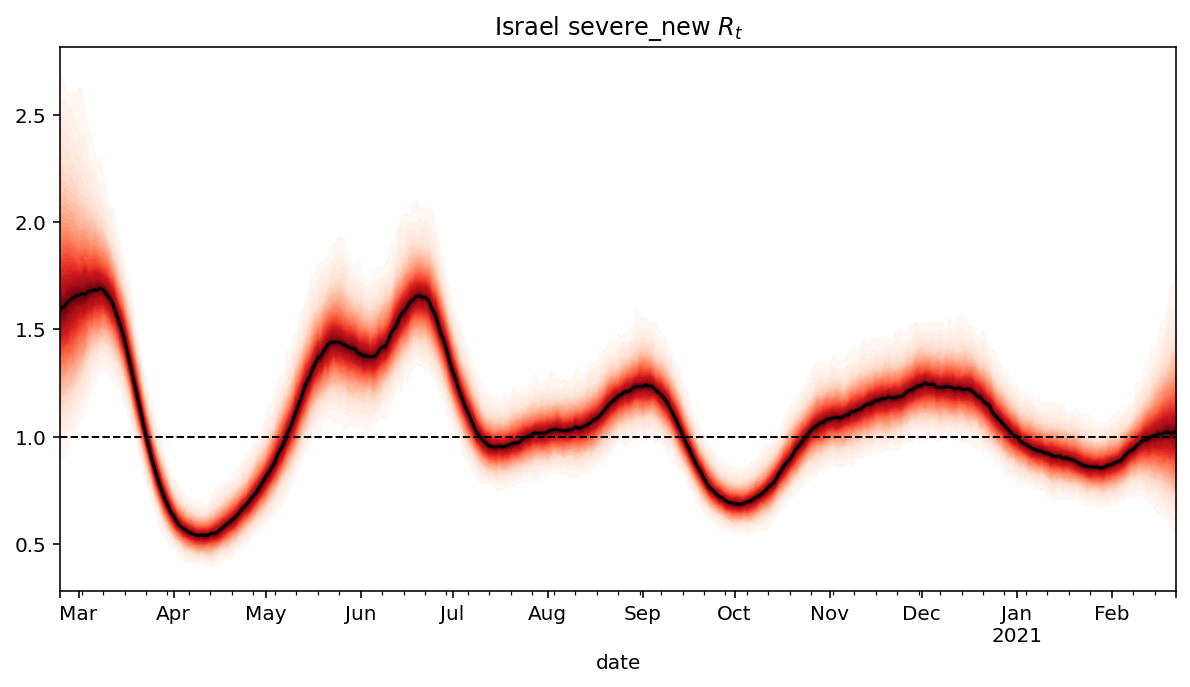

In [15]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"{region} severe_new $R_t$")
samples = gmsev.trace['r_t']
x=resultsev.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

resultsev["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
fig.set_facecolor('w')

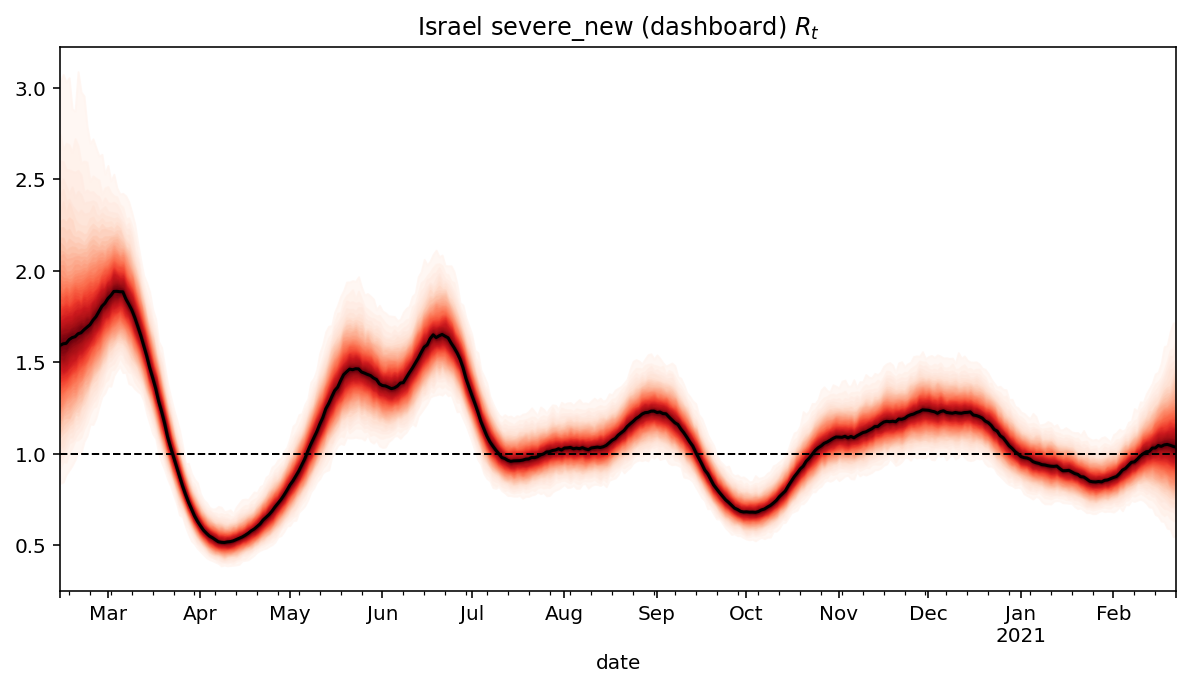

In [16]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"{region} severe_new (dashboard) $R_t$")
samples = gmsevdash.trace['r_t']
x=resultsevdash.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

resultsevdash["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
fig.set_facecolor('w')

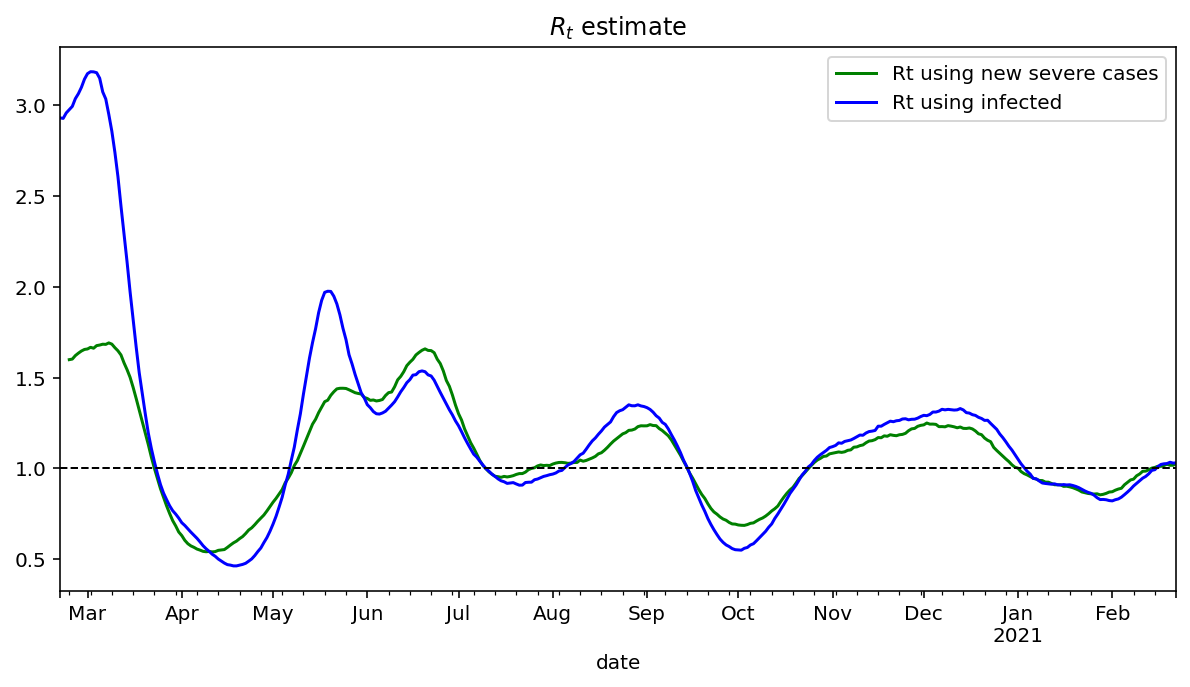

In [17]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title(f"$R_t$ estimate")
resultsev["median"].plot(c="g", ls='-', label="Rt using new severe cases")
#resultsevdash["median"].plot(c="r", ls='-', label="Rt using new severe cases from dashboard")
resultunn["median"].plot(c="b", ls='-', label="Rt using infected")
ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
ax.legend()

In [18]:
resultunn.to_csv("results_unnormalized_out.csv")

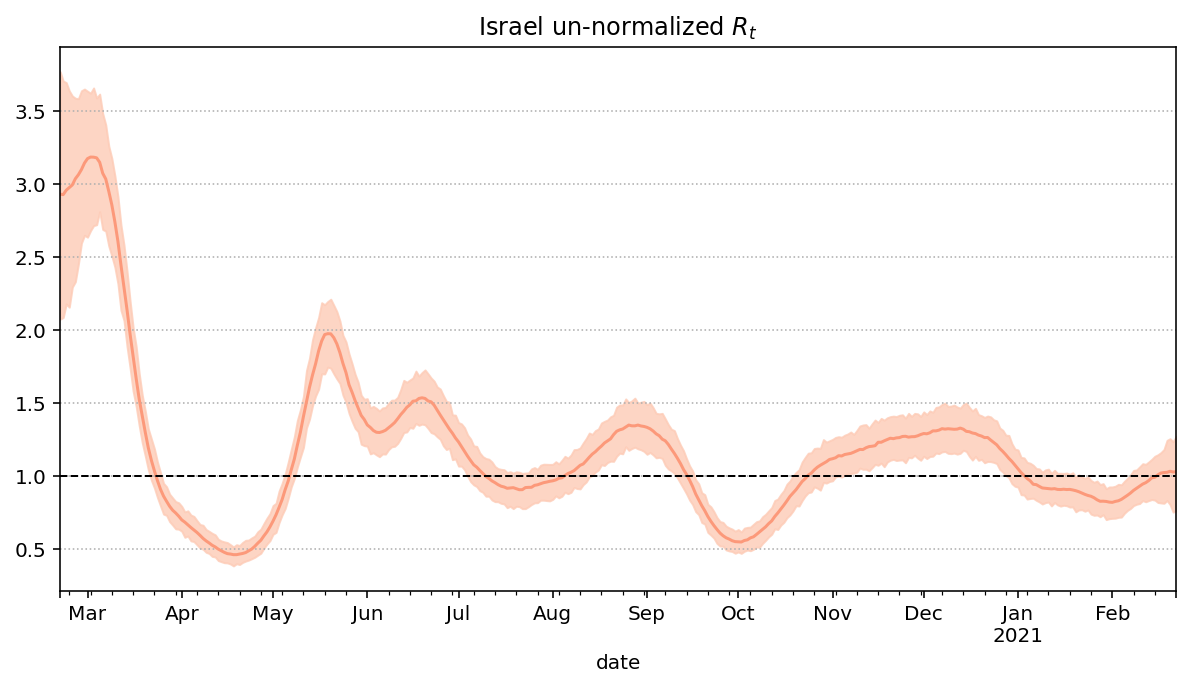

In [19]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"{region} un-normalized $R_t$")
samples = gmunn.trace['r_t']
x=resultunn.index
cmap = plt.get_cmap("Reds")
ax.fill_between(x, resultunn["upper_80"], resultunn["lower_80"], color=cmap(50), alpha=.8)
resultunn["median"].plot(c=cmap(90), ls='-', label="Rt using infected")
ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
#ax.set_xlim(left = pd.Timestamp.today()-pd.Timedelta(days=70), right=pd.Timestamp.today()-pd.Timedelta(days=10))
#ax.set_ylim(top = 2)
fig.set_facecolor('w')
plt.grid(which='major', axis='y', ls=':')
fig.savefig("Israel_unnorm_Rt_est.svg")